# PWA System Identification

In this notebook, we implement some methods for PWA system identification. The identification problem for a fixed number of regions can be posed as
$$ \min_{\Theta, \mathcal{R}} \frac{1}{M} \sum_{\ell=1}^M\sum_{i=1}^s \mathbf{1}_{z_\ell\in\mathcal{R}_i}\textrm{loss}(y_\ell - \theta_i^\top \begin{bmatrix} z_\ell \\ 1\end{bmatrix}) $$
which is a mixed integer problem, and is NP-hard to solve [cite]. Instead, we will investigate solving the problem by two approaches: a convex relaxation that has recovery guarantees with some assumptions, and a greedy alternating algorithm for clustering. 

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.linalg as la
import sys

sys.path.append('../src')
import pwa_cluster as pwac

## Data Generation

Recall that a PWA system takes the following form
$$ y = \theta_i^\top \begin{bmatrix} z \\ 1 \end{bmatrix}, \quad z\in\mathcal{R}_i $$
Furthermore, recall that affine regions $\{\mathcal{R}_i\}_{i\in[s]}$ can be defined by $\{w_i\in\mathbb{R}^{d+1}\}_{i\in[s]}$
$$ z\in\mathcal{R}_i \iff i = \arg\max_{j\in[s]} w_j^\top \begin{bmatrix} z \\ 1 \end{bmatrix} $$

In this section, we write methods for generating noisy data. We will both generate data from a truly PWA system and from a nonlinear system that may be approximated as PWA.

In [92]:
def affine_fn(x, region, affines):
    return affines[region(x)].transpose().dot(np.hstack([x, [1]]))

def generate_affine_fn(d, n, s):
    affines = [np.random.rand(d+1, n) for i in range(s)]
    region_weights = [4*np.random.rand(d+1) for i in range(s)]
    def region(x):
        dot_pdt = [region_weight.transpose().dot(np.hstack([x, [1]])) for region_weight in region_weights]
        return np.argmax(dot_pdt)
    return lambda x: affine_fn(x, region, affines), region, affines
        
    


In [93]:
f, region, affines = generate_affine_fn(2, 1, 3)

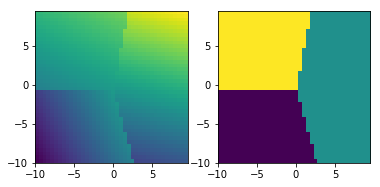

In [94]:
grid_size = 0.5
x = np.arange(-10,10,grid_size)
N_grid = len(x)

y = np.zeros([N_grid,N_grid])
regions = np.zeros([N_grid,N_grid])
xs = []
for i in range(N_grid):
    for j in range(N_grid):
        perturb = 0.25 * np.random.rand(2)
        y[i,j] = f([x[i],x[j]])
        regions[i,j] = region([x[i],x[j]])
        xs.append([x[i],x[j]])

plt.figure(); 
plt.subplot(1,2,1)
plt.imshow(y, interpolation='none', origin='lower',  extent=(min(x), max(x), min(x), max(x)))
plt.subplot(1,2,2)
plt.imshow(regions, interpolation='none', origin='lower',  extent=(min(x), max(x), min(x), max(x)))

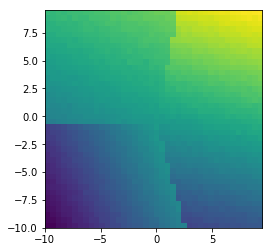

In [95]:
zs = np.array(xs)
ys = []
for z in zs:
    ys.append(f(z) + 0.1 * np.random.randn(1))
ys = np.array(ys)

plt.figure(); plt.imshow(ys.reshape(N_grid, N_grid), interpolation='none', origin='lower',  extent=(min(x), max(x), min(x), max(x)))


In [96]:
# to do: implement some realistic-ish nonlinear function (using the bicycle model?)

## Greedy Alternating Approach

In [97]:

clustering = pwac.ClusterPWA(zs, ys, 3, z_cutoff = 1)


In [98]:
clustering.fit_clusters(verbose=True)

assigning datapoints to clusters
updating models
2.04519439714
assigning datapoints to clusters
updating models
0.0430765359087
assigning datapoints to clusters
updating models
0.0779952400286
assigning datapoints to clusters
updating models
0.0303113842396
assigning datapoints to clusters
updating models
0.0227430853756
assigning datapoints to clusters
updating models
0.00661095995856
assigning datapoints to clusters
updating models
0.0128884345774
assigning datapoints to clusters
updating models
0.0153104102894
assigning datapoints to clusters
updating models
0.0
done


In [99]:
centroids = clustering.centroids
cluster_labels = clustering.cluster_labels
thetas = clustering.thetas

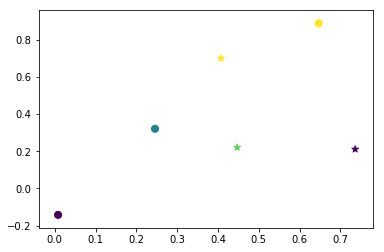

In [100]:
true_thetas = np.array(affines).transpose()[0]

plt.figure(); plt.scatter(thetas[0], thetas[1], c=thetas[2], s=50)
plt.scatter(true_thetas[0], true_thetas[1], c=true_thetas[2], s=50,  marker='*')

(-10.996684587813622,
 10.49668458781362,
 -10.990176600441503,
 10.490176600441501)

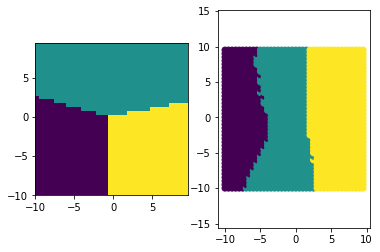

In [101]:
plt.figure();
plt.subplot(1,2,1);
plt.imshow((regions).T, interpolation='none', origin='lower',  extent=(min(x), max(x), min(x), max(x)))

plt.subplot(1,2,2); plt.scatter(zs[:,0], zs[:,1], c=cluster_labels); plt.axis('equal')


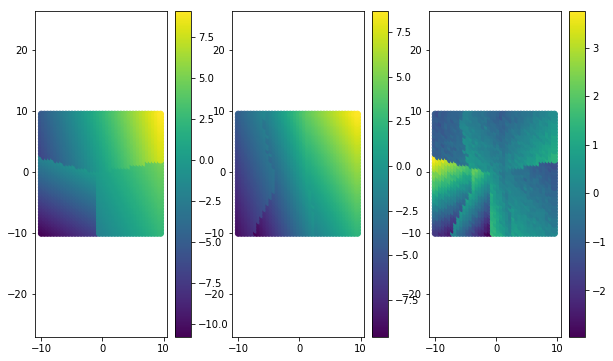

In [102]:
yhats = []
for i in range(zs.shape[0]):
    yhat = thetas[int(cluster_labels[i])].transpose().dot(np.hstack([zs[i], 1]))
    yhats.append(yhat)

plt.figure(figsize=[10,6]); 
plt.subplot(1,3,1)
plt.scatter(zs[:,0], zs[:,1], c=y); plt.axis('equal'); plt.colorbar()
plt.subplot(1,3,2)
#plt.imshow(yhat, interpolation='none', origin='lower',  extent=(min(x), max(x), min(x), max(x)))
plt.scatter(zs[:,0], zs[:,1], c=yhats); plt.axis('equal'); plt.colorbar()
plt.subplot(1,3,3)
#plt.imshow(yhat, interpolation='none', origin='lower',  extent=(min(x), max(x), min(x), max(x)))
plt.scatter(zs[:,0], zs[:,1], c=(ys-yhats)); plt.axis('equal'); plt.colorbar()

## Clustering

In [110]:
import cvxpy as cvx 

def cvx_problem(zs, labels):
    s = np.unique(labels).size
    
    Ms = []
    ms = []
    ws = []
    for i in range(s):
        selected_z = zs[np.where(cluster_labels == 0)]
        num_selected = selected_z.shape[0]
        M = np.hstack([selected_z,np.ones([num_selected,1])])
        Ms.append(M); ms.append(num_selected)
        ws.append(cvx.Variable(zs[0].size + 1,1))
        
    cost = 0
    constr = []
    for i in range(s):
        for j in range(s):
            if i == j: continue;
            expr = Ms[i] * (ws[j] - ws[i]) + np.ones([ms[i],1])
            cost = cost + np.ones(ms[i]) * ( cvx.pos(expr) ) / ms[i]
            
    return cvx.Problem(cvx.Minimize(cost)), ws
    

In [111]:
zs_cutoff = []
for z in zs:
    zs_cutoff.append(z[0:1])
zs_cutoff = np.array(zs_cutoff)
prob, ws = cvx_problem(zs_cutoff, cluster_labels)

In [112]:
zs_cutoff

array([[-10. ],
       [-10. ],
       [-10. ],
       ..., 
       [  9.5],
       [  9.5],
       [  9.5]])

In [113]:
prob.solve(verbose=True)


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +9.191e-01  +1.153e+01  +8e+01  8e-01  4e-01  1e+00  2e-02    ---    ---    2  1  - |  -  - 
 1  +5.436e+00  +6.409e+00  +1e+01  6e-02  5e-02  6e-03  3e-03  0.8586  2e-02   1  1  1 |  0  0
 2  +5.984e+00  +6.048e+00  +9e-01  4e-03  3e-03  4e-04  2e-04  0.9351  4e-03   1  0  0 |  0  0
 3  +6.000e+00  +6.001e+00  +1e-02  4e-05  3e-05  4e-06  2e-06  0.9890  1e-04   0  0  0 |  0  0
 4  +6.000e+00  +6.000e+00  +1e-04  4e-07  4e-07  5e-08  2e-08  0.9890  1e-04   2  0  0 |  0  0
 5  +6.000e+00  +6.000e+00  +1e-06  5e-09  4e-09  5e-10  2e-10  0.9890  1e-04   1  0  0 |  0  0
 6  +6.000e+00  +6.000e+00  +1e-08  5e-11  5e-11  6e-12  3e-12  0.9890  1e-04   3  0  0 |  0  0

OPTIMAL (within feastol=5.5e-11, reltol=2.2e-09, abstol=1.3e-08).
Runtime: 0.012986 seconds.



5.999999999790663

In [114]:
for w in ws:
    print(w.value)

[[  8.10324830e-07]
 [ -8.80586359e-06]]
[[  8.10643314e-07]
 [ -8.80336292e-06]]
[[  8.10362652e-07]
 [ -8.80542140e-06]]


In [115]:
def region(x):
    dot_pdt = [w.value.transpose().dot(np.hstack([x, [1]])) for w in ws]
    return np.argmax(dot_pdt)

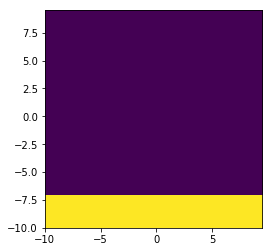

In [116]:
regions = np.zeros([N_grid,N_grid])
for i in range(N_grid):
    for j in range(N_grid):
        regions[i,j] = region([x[i]])

plt.figure(); 
plt.imshow(regions, interpolation='none', origin='lower',  extent=(min(x), max(x), min(x), max(x)))

## Convex Relaxation

In this section, we explore and implement a convex relaxation the the PWA identification problem. We focus on the heuristic in [2] 
$$ \min_\Theta \sum_{\ell=1}^M \|\Lambda_e^{-1/2}(y_\ell - \theta_\ell^\top \begin{bmatrix} z_\ell \\ 1\end{bmatrix})\|_2^2 + \lambda\sum_{k,j=1}^M K(z_k, z_j)\|\theta_k-\theta_j\|_1
 $$

This convex problem is implemented using cvxpy.

[2] Henrik Ohlsson and Lennart Ljung, Identification of Piecewise Affine Systems Using  Sum-of-Norms Regularization

In [198]:
import cvxpy as cvx

## method for taking data points into cvxpy problem and solving it
def cvx_problem(ys, zs, kernel, lambda_err, lambda_reg):
    n = ys[0].size
    d = zs[0].size
    M = len(ys)
    
    thetas = cvx.Variable(d+1, n * M)
    
    cost = 0
    for i in range(M):
        print(i)
        fit = ys[i] - thetas[:,i*n:(1+i):n].T * np.hstack([zs[i], 1])
        # todo, assert lambda_err PSD
        cost = cost + cvx.quad_form(fit, la.inv(la.sqrtm(lambda_err)) )
        #costs.append(cvx.Problem(cvx.Minimize(cost)))
    
    for i in range(M):
        print(i)
        for j in range(i+1,M):
            cost = cost + lambda_reg * kernel(zs[i], zs[j]) * cvx.norm(thetas[:,i*n:(1+i):n]-thetas[:,j*n:(1+j):n], 1 )
            # low rank in unrolled matrix instead of l0 norm on vectors!
            #costs.append(cvx.Problem(cvx.Minimize(cost)))
            
    return cvx.Problem(cvx.Minimize(cost)), thetas
    
    

In [40]:
def proximity_kernel(z1, z2, size):
    if np.linalg.norm(z1-z2) < size:
        return 1
    else:
        return 0

In [41]:
kernel = lambda z1, z2: proximity_kernel(z1, z2, 1)
lambda_err = np.eye(1)
lambda_reg = 2

In [42]:
prob, thetas = cvx_problem(ys, zs, kernel, lambda_err, lambda_reg)


NameError: name 'cvx_problem' is not defined

In [42]:
prob.solve(verbose=True)


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -1.509e-15  -3.560e+01  +8e+03  8e-01  4e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  +6.576e+00  +2.651e+00  +2e+03  2e-01  5e-02  6e-01  5e-01  0.8759  1e-01   1  1  2 |  0  0
 2  +1.919e+01  +1.827e+01  +4e+02  5e-02  1e-02  1e-01  1e-01  0.7717  3e-02   2  2  2 |  0  0
 3  +2.582e+01  +2.506e+01  +3e+02  4e-02  8e-03  9e-02  1e-01  0.4901  6e-01   2  2  2 |  0  0
 4  +3.287e+01  +3.263e+01  +1e+02  1e-02  3e-03  2e-02  3e-02  0.7347  7e-02   2  2  2 |  0  0
 5  +3.433e+01  +3.414e+01  +8e+01  1e-02  2e-03  1e-02  3e-02  0.4928  5e-01   2  2  2 |  0  0
 6  +3.608e+01  +3.601e+01  +3e+01  4e-03  7e-04  5e-03  1e-02  0.6780  7e-02   2  2  2 |  0  0
 7  +3.616e+01  +3.609e+01  +3e+01  4e-03  6e-04  4e-03  9e-03  0.2647  7e-01   2  2  2 |  0  0
 8  +3.656e+01  +3.653e+01  +1e+01  2e-03  3e-

36.87066719039882

In [43]:
resulting_thetas = np.array(thetas.value)
true_thetas = np.array(affines).transpose()[0]

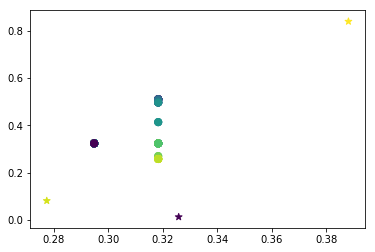

In [44]:
plt.figure(); plt.scatter(resulting_thetas[0], resulting_thetas[1], c=resulting_thetas[2], s=50)
plt.scatter(true_thetas[0], true_thetas[1], c=true_thetas[2], s=50,  marker='*')

In [ ]:
## old clustering
import cvxpy as cvx

## method for taking data points into cvxpy problem and solving it
def cvx_problem(zs, labels):
    s = np.unique(labels).size
    
    Ms = []
    ms = []
    ws = []
    for i in range(s):
        selected_z = zs[np.where(cluster_labels == 0)]
        num_selected = selected_z.shape[0]
        M = np.hstack([selected_z,np.ones([num_selected,1])])
        Ms.append(M); ms.append(num_selected)
        ws.append(cvx.Variable(zs[0].size + 1,1))
        
    ys = []
    cost = 0
    constr = []
    for i in range(s):
        for j in range(s):
            if i == j: continue;
            ys.append(cvx.Variable(ms[i]))
            cost = cost + np.ones(ms[i]).dot(ys[-1]) / ms[i]
            print(Ms[i].shape)
            print(ws[j], ws[i], ys[-1])
            constr.append(0 >= Ms[i] * ws[j] + np.ones([ms[i],1]) )
            #constr = constr + [ys[-1] >= Ms[i].dot(ws[j] - ws[i]) + np.ones([ms[i],1]), ys[-1] >= 0]
            
    return cvx.Problem(cvx.Minimize(cost), constr), thetas
    
    